In [ ]:
import time

import numpy as np
import torch

import quairkit as qkit
from quairkit import Circuit, to_state
from quairkit.database import *
from quairkit.qinfo import *

qkit.set_dtype("complex128")

Set up the basic parameters of the training ansatz.

In [35]:
m, na = 4, 3
num_V = m + 1
num_qubits = na + 2 * num_V
dim = 2 ** num_qubits

num_test = 10000

Set up the parameters of the training process.

In [36]:
LR = 0.1
NUM_ITR = 2000

Calculate the performance operator for calculating the loss function.

In [37]:
test_dataset = [haar_unitary(2) for _ in range(num_test)]

omega = 0
for u in test_dataset:
    u_dag_choi = channel_repr_convert(dagger(u), source='kraus', target='choi')
    u_conj_choi = channel_repr_convert(u.conj(), source='kraus', target='choi')
    
    if m == 1:
        omega += torch.kron(u_dag_choi, u_conj_choi)
    else:
        omega += torch.kron(u_dag_choi, NKron(*[u_conj_choi for _ in range(m)]))
omega /= num_test

# find the permutation
orig_perm = [0, 2 * num_V - 1] + sum(([2 * j - 1, 2 * j] for j in range(1, num_V)), [])
targ_perm = list(range(2 * num_V))
perm_map = {val: index for index, val in enumerate(orig_perm)}
perm_map = [perm_map[val] for val in targ_perm]

# permute omega to match system
omega = permute_systems(omega, perm_map, [2, 2] * num_V)

Define the input state and projector.

In [ ]:
if na > 0:
    input_state = zero_state(na).ket
    for _ in range(num_V):
        input_state = torch.kron(input_state, bell_state(2).ket)
else:
    input_state = bell_state(2).ket
    for _ in range(num_V - 1):
        input_state = torch.kron(input_state, bell_state(2).ket)
input_state = to_state(input_state)

proj_zero = zero_state(1)
proj_zero = torch.kron(proj_zero.bra, torch.eye(2 ** (2 * num_V + na - 1)))

Define the function for evaluating the circuit.

In [ ]:
def average_fidelity(circuit: Circuit) -> torch.Tensor:
    r"""Compute average fidelity of the input comb
    """
    output_state = circuit(input_state)
    
    output_state = proj_zero @ output_state.ket
    choi_comb = partial_trace(output_state @ output_state.conj().T,
                              0, [2 ** (na - 1), 2 ** (2 * num_V)]) * (2 ** num_V)
    return torch.trace(choi_comb @ omega).real / 4

Create the ansatz to be trained.

In [ ]:
list_applied_idx = [(list(range(na)) + [na + 2 * j + 1]) for j in range(num_V)]

def create_circuit(param_uni1: torch.Tensor, param_uni2: torch.Tensor, param_uni3: torch.Tensor) -> Circuit:
    circuit = Circuit(num_qubits)
    G = universal3(param_uni3)
    
    for idx, qubit_idx in enumerate(list_applied_idx):
        if idx == 0:
            circuit.h([qubit_idx[1], qubit_idx[2]])
            circuit.cx([qubit_idx[2], qubit_idx[3]])
            circuit.cy([qubit_idx[1], qubit_idx[3]])
        
        elif idx == 1:
            circuit.cy([qubit_idx[1], qubit_idx[3]])
            circuit.cx([qubit_idx[2], qubit_idx[3]])
            
            circuit.oracle(G, system_idx=qubit_idx[:-1], latex_name=r'$G := \textrm{Uni}_8$')
            circuit.u3(qubit_idx[0], param=param_uni1[0])
            
            circuit.cx([qubit_idx[2], qubit_idx[3]])
            circuit.cy([qubit_idx[1], qubit_idx[3]])
        
        elif idx == 2:
            circuit.cy([qubit_idx[1], qubit_idx[3]])
            circuit.cx([qubit_idx[2], qubit_idx[3]])
            
            circuit.oracle(dagger(G), system_idx=qubit_idx[:-1], latex_name=r'$G^\dagger$')
            
            circuit.cx([qubit_idx[2], qubit_idx[3]])
            circuit.cy([qubit_idx[1], qubit_idx[3]])
        
        elif idx == 3:
            circuit.cy([qubit_idx[1], qubit_idx[3]])
            circuit.cx([qubit_idx[2], qubit_idx[3]])
            
            circuit.universal_two_qubits([qubit_idx[1], qubit_idx[2]], param=param_uni2[0])
            circuit.oracle(G, system_idx=qubit_idx[:-1], latex_name=r'$G$')
            circuit.u3(qubit_idx[0], param=param_uni1[1])
            
            circuit.cx([qubit_idx[2], qubit_idx[3]])
            circuit.cy([qubit_idx[1], qubit_idx[3]])
            
        elif idx == 4:
            circuit.cy([qubit_idx[1], qubit_idx[3]])
            circuit.cx([qubit_idx[2], qubit_idx[3]])
            
            circuit.oracle(dagger(G), system_idx=qubit_idx[:-1], latex_name=r'$G^\dagger$')
            circuit.universal_two_qubits([qubit_idx[1], qubit_idx[2]], param=param_uni2[1])
            
            circuit.cy([qubit_idx[2], qubit_idx[3]])
            circuit.cx([qubit_idx[1], qubit_idx[3]])
            
    return circuit
            

class TrainAnsatz(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.param_uni1 = torch.nn.Parameter(torch.rand(2, 3))
        self.param_uni2 = torch.nn.Parameter(torch.rand(2, 15))
        self.param_uni3 = torch.nn.Parameter(torch.rand(81))
        
    def forward(self) -> Circuit:
        return create_circuit(self.param_uni1, self.param_uni2, self.param_uni3)

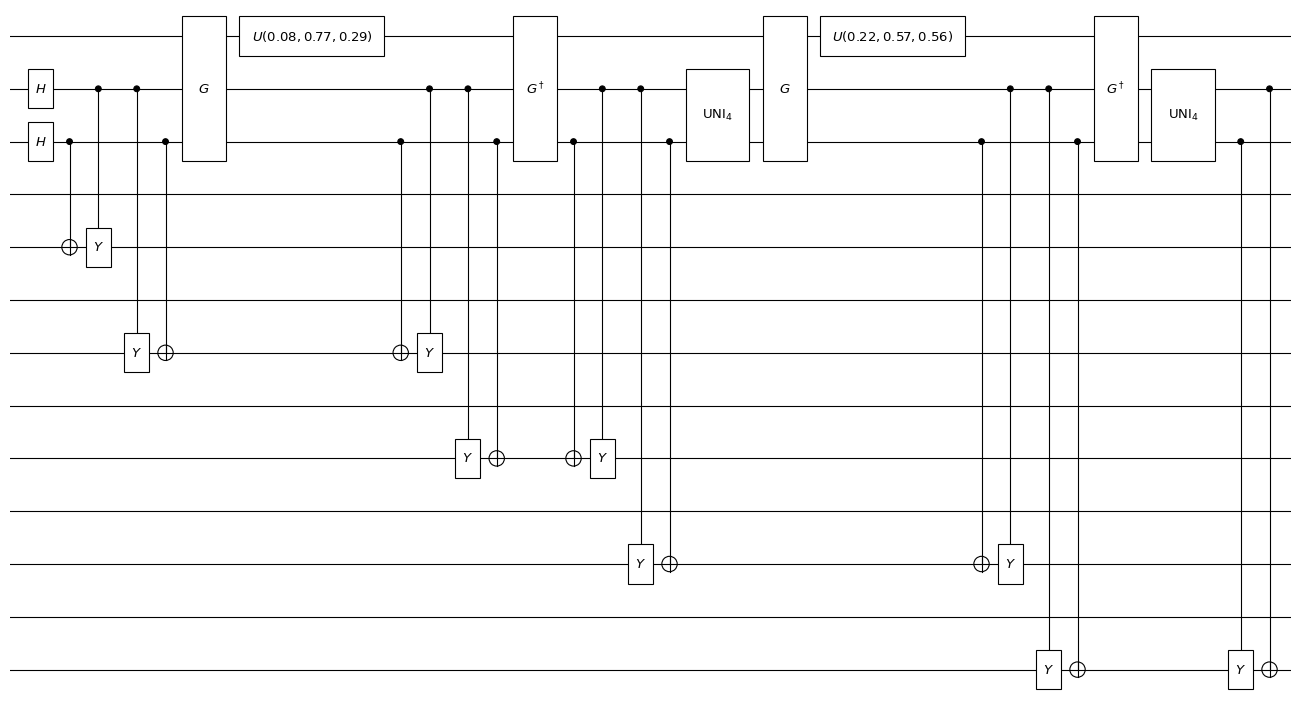

In [40]:
net = TrainAnsatz()
net().plot()

Train the ansatz.

In [41]:
loss_list, time_list = [], []

opt = torch.optim.Adam(lr=LR, params=list(net.parameters()))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', verbose=True, factor=0.5)

for itr in range(NUM_ITR):
    start_time = time.time()
    
    opt.zero_grad()
    loss = 1 - average_fidelity(net())
    loss.backward()
    opt.step()
    scheduler.step(loss)

    loss = loss.item()
    loss_list.append(loss)
    time_list.append(time.time() - start_time)
    
    if itr % 40 == 0 or itr == NUM_ITR - 1 or loss < 1e-6:
        print(f"iter: {itr}, fidelity: {1 - loss:.8f}, avg_time: {np.mean(time_list):.4f}s")
        time_list = []
        
    if loss < 1e-6:
        break

iter: 0, fidelity: 0.12564418, avg_time: 0.8695s
iter: 40, fidelity: 0.81331318, avg_time: 0.6232s
iter: 80, fidelity: 0.96547562, avg_time: 0.6590s
iter: 120, fidelity: 0.98939899, avg_time: 0.6525s
iter: 160, fidelity: 0.99452925, avg_time: 0.6904s
iter: 200, fidelity: 0.99789853, avg_time: 0.6448s
iter: 240, fidelity: 0.99936347, avg_time: 0.7210s
iter: 280, fidelity: 0.99978036, avg_time: 0.7366s
iter: 320, fidelity: 0.99770812, avg_time: 0.7297s
iter: 360, fidelity: 0.99986790, avg_time: 0.7314s
iter: 400, fidelity: 0.99989205, avg_time: 0.7423s
iter: 440, fidelity: 0.99989854, avg_time: 0.7495s
iter: 480, fidelity: 0.99990401, avg_time: 0.7551s
iter: 520, fidelity: 0.99990906, avg_time: 0.7529s
iter: 560, fidelity: 0.99991383, avg_time: 0.7611s
iter: 600, fidelity: 0.99991838, avg_time: 0.8000s
iter: 640, fidelity: 0.99992275, avg_time: 0.7751s
iter: 680, fidelity: 0.99992694, avg_time: 0.7712s
iter: 720, fidelity: 0.99993095, avg_time: 0.7459s
iter: 760, fidelity: 0.99993479, av